In [27]:
!nvidia-smi

Thu Jun  8 10:34:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:B1:00.0 Off |                  N/A |
| 22%   25C    P8     5W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:B2:00.0 Off |                  N/A |
| 22%   

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [29]:
print(tf.__version__)

2.11.0


In [30]:
'''
Methodology : 

1. Use an rcnn model to achieve bounding box coordinates (Object detection) for a class
2. Compare saliency in only areas within the bounding box

'''
#object detection vs segmentation

'\nMethodology : \n\n1. Use an rcnn model to achieve bounding box coordinates (Object detection) for a class\n2. Compare saliency in only areas within the bounding box\n\n'

/project/validating_attribution_techniques/juneja
/project/validating_attribution_techniques/commons/examples/plane.png


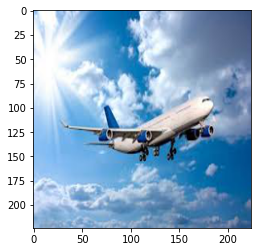

In [31]:
#load image

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

#set proxy variables
os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
print(os.getcwd())

base_dir='/project/validating_attribution_techniques/commons/examples/'
img_path=base_dir+'plane.png'

print(img_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# cv2.imshow('plane', plane_arr)

In [32]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [33]:
#STEP1: load a model architecture from detectron model zoo

os.environ['CUDA_VISIBLE_DEVICES']='2, 3'

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# predictor = DefaultPredictor(cfg)
# outputs = predictor(im)

In [34]:
predictor = DefaultPredictor(cfg)


[06/08 10:34:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [35]:
outputs = predictor(img)

In [36]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([36,  4], device='cuda:0')
Boxes(tensor([[ 67.0590,  87.4678, 187.6084, 154.1498],
        [ 28.5862,  81.8786, 192.4542, 153.0460]], device='cuda:0'))


[]

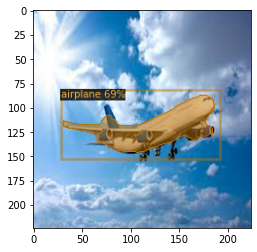

In [37]:
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)

out = v.draw_instance_predictions(outputs["instances"][1].to("cpu"))

plt.imshow(out.get_image()[:, :, ::-1])

plt.plot()

[06/08 10:38:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...
[{'id': 1, 'isthing': True, 'score': 0.5625963807106018, 'category_id': 36, 'instance_id': 0}, {'id': 2, 'isthing': False, 'category_id': 37, 'area': 5415}, {'id': 3, 'isthing': False, 'category_id': 52, 'area': 13585}]


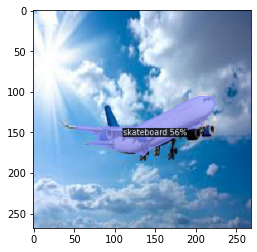

In [43]:
#Segmentation

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)

panoptic_seg, segments_info = predictor(img)["panoptic_seg"]
print(segments_info)
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), [segments_info[0]])

plt.imshow(out.get_image()[:, :, ::-1])

In [ ]:
#calculate overlay area in between the object mask and the most salient region thresholds.